In [1]:
# install the dependencies
!pip install kaggle 

In [2]:
from google.colab import files
files.upload() # load kaggle.json file from your computer

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"balnyaupane","key":"71e9f0cd682737702ecf3ca744f61455"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d balnyaupane/pneumonia-chest-xray-small-dataset -p /content

 97% 177M/183M [00:01<00:00, 98.1MB/s]
100% 183M/183M [00:01<00:00, 102MB/s] 


In [5]:
!unzip -uq "/content/pneumonia-chest-xray-small-dataset.zip" -d "/content/Dataset"

In [6]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense,Dropout,Input
from keras.layers import Flatten
from keras_preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.layers import Activation
from keras.layers import BatchNormalization,Concatenate
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# image size
img_size= 512
img_input = Input(shape=(img_size, img_size, 1))
img_concate = Concatenate()([img_input, img_input, img_input])  

# loading VGG16 model
# include_top: whether to include the fully-connected layers at the top of the network.
model=VGG16(weights='imagenet', include_top=False, input_tensor=img_concate)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Layers in VGG16 midel
for (i,layer) in enumerate(model.layers):
    print(str(i)+ " "+layer.__class__.__name__,layer.trainable)
    
# layers are by default trainable, so make it non trainable.
for layer in model.layers:
    layer.trainable=False
print("======================================================")   
# lets check the layer become trainable=Fale or Not.
for (i,layer) in enumerate(model.layers):
    print(str(i)+ " "+layer.__class__.__name__,layer.trainable)

0 InputLayer True
1 Concatenate True
2 Conv2D True
3 Conv2D True
4 MaxPooling2D True
5 Conv2D True
6 Conv2D True
7 MaxPooling2D True
8 Conv2D True
9 Conv2D True
10 Conv2D True
11 MaxPooling2D True
12 Conv2D True
13 Conv2D True
14 Conv2D True
15 MaxPooling2D True
16 Conv2D True
17 Conv2D True
18 Conv2D True
19 MaxPooling2D True
0 InputLayer False
1 Concatenate False
2 Conv2D False
3 Conv2D False
4 MaxPooling2D False
5 Conv2D False
6 Conv2D False
7 MaxPooling2D False
8 Conv2D False
9 Conv2D False
10 Conv2D False
11 MaxPooling2D False
12 Conv2D False
13 Conv2D False
14 Conv2D False
15 MaxPooling2D False
16 Conv2D False
17 Conv2D False
18 Conv2D False
19 MaxPooling2D False


In [ ]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='VGG16.png')

In [ ]:
# Now adding fully connected Layer on the ResNet101
flatLayer=model.output
fullConnected=Flatten()(flatLayer)

fullConnected=Dense(128,kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-4))(fullConnected)
fullConnected=BatchNormalization()(fullConnected)
fullConnected=Activation(activation='relu')(fullConnected)
fullConnected=Dropout(0.5)(fullConnected)

fullConnected=Dense(64,kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-4))(fullConnected)
fullConnected=BatchNormalization()(fullConnected)
fullConnected=Activation(activation='relu')(fullConnected)
fullConnected=Dropout(0.5)(fullConnected)

fullConnected=Dense(32,kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-4))(fullConnected)
fullConnected=BatchNormalization()(fullConnected)
fullConnected=Activation(activation='relu')(fullConnected)


output=Dense(1, activation='sigmoid')(fullConnected)
print("model.input:  ",model.input)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# Model summarary
model.summary()

model.input:   KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512, 512, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)    

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0000015,beta_1=0.899,beta_2=0.999,epsilon=1e-06)

#compiling the cnn
model.compile(optimizer=opt , loss='binary_crossentropy',metrics=['accuracy'])

#part2- fitting the CNN to the images
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('/content/Dataset/Pneumonia_Chest _X-ray_Small_Dataset/Trainingdata',
        target_size=(512, 512),
        batch_size=52,
        color_mode='grayscale',
        class_mode='binary')

print("training_set.class_indices: ",training_set.class_indices)

test_set = test_datagen.flow_from_directory('/content/Dataset/Pneumonia_Chest _X-ray_Small_Dataset/Testdata',
        target_size=(512,512),
        batch_size=26,
        color_mode='grayscale',
        shuffle=False,
        class_mode='binary')

print("training_set.class_indices: ",training_set.class_indices)
print("test_set.class_indices: ",test_set.class_indices)
print(" print(len(training_set)):  ",len(training_set))
print(" print(len(test_set)):  ",len(test_set))

Found 2105 images belonging to 2 classes.
training_set.class_indices:  {'Normal': 0, 'Pneumonia': 1}
Found 480 images belonging to 2 classes.
training_set.class_indices:  {'Normal': 0, 'Pneumonia': 1}
test_set.class_indices:  {'Normal': 0, 'Pneumonia': 1}
 print(len(training_set)):   41
 print(len(test_set)):   19


In [ ]:
# simple early stopping
my_callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=5,verbose=1)]

In [ ]:
History = model.fit(training_set, 
                    validation_data= test_set, 
                    steps_per_epoch=len(training_set),
                    epochs=100,
                    validation_steps=len(test_set),
                    verbose=1,
                    callbacks=my_callbacks
                 )

Epoch 1/100
41/41 [==============================] - 300s 5s/step - loss: 58.1507 - accuracy: 0.5596 - val_loss: 57.8314 - val_accuracy: 0.5708
Epoch 2/100
41/41 [==============================] - 116s 3s/step - loss: 57.4716 - accuracy: 0.6556 - val_loss: 57.1465 - val_accuracy: 0.6604
Epoch 3/100
41/41 [==============================] - 116s 3s/step - loss: 56.8620 - accuracy: 0.6931 - val_loss: 56.5145 - val_accuracy: 0.7563
Epoch 4/100
41/41 [==============================] - 116s 3s/step - loss: 56.2436 - accuracy: 0.7359 - val_loss: 55.9043 - val_accuracy: 0.8208
Epoch 5/100
41/41 [==============================] - 115s 3s/step - loss: 55.6406 - accuracy: 0.7601 - val_loss: 55.3042 - val_accuracy: 0.8521
Epoch 6/100
41/41 [==============================] - 115s 3s/step - loss: 55.0424 - accuracy: 0.7781 - val_loss: 54.7102 - val_accuracy: 0.8687
Epoch 7/100
41/41 [==============================] - 115s 3s/step - loss: 54.4350 - accuracy: 0.8014 - val_loss: 54.1147 - val_accuracy:

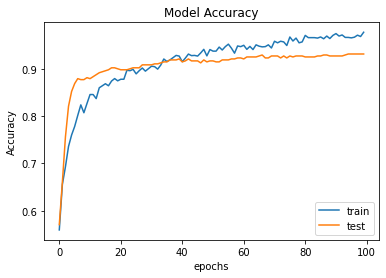

In [ ]:
# summarize history for accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

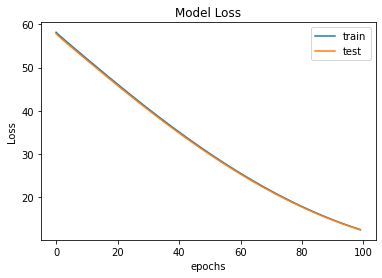

In [ ]:
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
## calculate model's accuracy on test set with use of keras .evaluate_generator() function.
scoreTest = model.evaluate(test_set)
print("Test Accuracy: ",scoreTest[1]*100)

scoreTrain = model.evaluate(training_set)
print("Training Accuracy: ",scoreTrain[1]*100)

preds = model.predict(test_set)
y_preds = np.where(preds >=0.5, 1, 0)

cfm = confusion_matrix(test_set.classes, y_preds)
print("============Confusion Matrix=====================",cfm)
print("=========Classification_Report==================",classification_report(test_set.classes, y_preds))

19/19 [==============================] - 23s 1s/step - loss: 12.4972 - accuracy: 0.9312
Test Accuracy:  93.12499761581421
41/41 [==============================] - 91s 2s/step - loss: 12.4151 - accuracy: 0.9976
Training Accuracy:  99.76246953010559
============Confusion Matrix===================== [[210  25]
 [  8 237]]
=========Classification_Report==================               precision    recall  f1-score   support

           0       0.96      0.89      0.93       235
           1       0.90      0.97      0.93       245

    accuracy                           0.93       480
   macro avg       0.93      0.93      0.93       480
weighted avg       0.93      0.93      0.93       480



In [ ]:
#test_set.classes

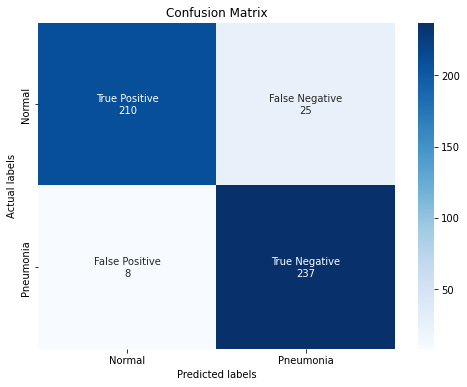

In [ ]:
group_names = ["True Positive","False Negative","False Positive","True Negative"]
group_counts = ['{0:0.0f}'.format(value) for value in cfm.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cfm, annot=labels, fmt='', cmap='Blues', ax = ax)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])
plt.show()

In [ ]:
# image size
img_size= 512
img_input = Input(shape=(img_size, img_size, 1))
img_concate = Concatenate()([img_input, img_input, img_input])  

# loading VGG16 model
# include_top: whether to include the fully-connected layers at the top of the network.
model=VGG16(weights='imagenet', include_top=False, input_tensor=img_concate)

# making all layer trainable
for layer in model.layers:
    layer.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 12
# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

# lets check the layer become trainable=Fale or Not.
for (i,layer) in enumerate(model.layers):
    print(str(i)+ " "+layer.__class__.__name__,layer.trainable)


# Now adding fully connected Layer on the ResNet101
flatLayer=model.output
fullConnected=Flatten()(flatLayer)

fullConnected=Dense(128,kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-4))(fullConnected)
fullConnected=BatchNormalization()(fullConnected)
fullConnected=Activation(activation='relu')(fullConnected)
fullConnected=Dropout(0.5)(fullConnected)

fullConnected=Dense(64,kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-4))(fullConnected)
fullConnected=BatchNormalization()(fullConnected)
fullConnected=Activation(activation='relu')(fullConnected)
fullConnected=Dropout(0.5)(fullConnected)

fullConnected=Dense(32,kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-4))(fullConnected)
fullConnected=BatchNormalization()(fullConnected)
fullConnected=Activation(activation='relu')(fullConnected)


output=Dense(1, activation='sigmoid')(fullConnected)
print("model.input:  ",model.input)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# Model summarary
model.summary()


from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0000015,beta_1=0.899,beta_2=0.999,epsilon=1e-07)

#compiling the cnn
model.compile(optimizer=opt , loss='binary_crossentropy',metrics=['accuracy'])

#part2- fitting the CNN to the images
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('/content/Dataset/Pneumonia_Chest _X-ray_Small_Dataset/Trainingdata',
        target_size=(512, 512),
        batch_size=32,
        color_mode='grayscale',
        class_mode='binary')

test_set = test_datagen.flow_from_directory('/content/Dataset/Pneumonia_Chest _X-ray_Small_Dataset/Testdata',
        target_size=(512,512),
        batch_size=16,
        color_mode='grayscale',
        shuffle=False,
        class_mode='binary')

print("test_set.class_indices: ",test_set.class_indices)
print("training_set.class_indices: ",training_set.class_indices)


# simple early stopping
my_callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=5,verbose=1)]

58900480/58889256 [==============================] - 1s 0us/step
0 InputLayer False
1 Concatenate False
2 Conv2D False
3 Conv2D False
4 MaxPooling2D False
5 Conv2D False
6 Conv2D False
7 MaxPooling2D False
8 Conv2D False
9 Conv2D False
10 Conv2D False
11 MaxPooling2D False
12 Conv2D True
13 Conv2D True
14 Conv2D True
15 MaxPooling2D True
16 Conv2D True
17 Conv2D True
18 Conv2D True
19 MaxPooling2D True
model.input:   KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Co

In [ ]:
History = model.fit(training_set, 
                    validation_data= test_set, 
                    steps_per_epoch=len(training_set),
                    epochs=100,
                    validation_steps=len(test_set),
                    verbose=1,
                    callbacks=my_callbacks
                 )

Epoch 1/100
66/66 [==============================] - 262s 3s/step - loss: 58.0157 - accuracy: 0.5534 - val_loss: 57.4413 - val_accuracy: 0.7167
Epoch 2/100
66/66 [==============================] - 139s 2s/step - loss: 57.0804 - accuracy: 0.6988 - val_loss: 56.5851 - val_accuracy: 0.8333
Epoch 3/100
66/66 [==============================] - 139s 2s/step - loss: 56.2405 - accuracy: 0.7515 - val_loss: 55.7588 - val_accuracy: 0.8813
Epoch 4/100
66/66 [==============================] - 139s 2s/step - loss: 55.4117 - accuracy: 0.8147 - val_loss: 54.9491 - val_accuracy: 0.8958
Epoch 5/100
66/66 [==============================] - 139s 2s/step - loss: 54.6228 - accuracy: 0.8200 - val_loss: 54.1502 - val_accuracy: 0.8979
Epoch 6/100
66/66 [==============================] - 139s 2s/step - loss: 53.8088 - accuracy: 0.8470 - val_loss: 53.3574 - val_accuracy: 0.9083
Epoch 7/100
66/66 [==============================] - 139s 2s/step - loss: 53.0154 - accuracy: 0.8575 - val_loss: 52.5734 - val_accuracy:

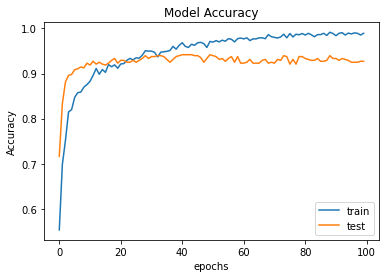

In [ ]:
# summarize history for accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

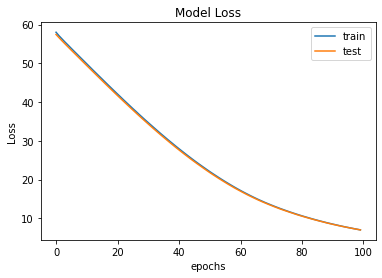

In [ ]:
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# calculate model's accuracy on test set with use of keras .evaluate_generator() function.
score = model.evaluate(test_set)
print("Test Accuracy: ",score[1]*100)

preds = model.predict(test_set)
y_preds = np.where(preds >=0.5, 1, 0)

cfm = confusion_matrix(test_set.classes, y_preds)

print("============Confusion Matrix=====================\n",cfm)
print("=========Classification_Report==================\n",classification_report(test_set.classes, y_preds))

30/30 [==============================] - 21s 691ms/step - loss: 7.0069 - accuracy: 0.9271
Test Accuracy:  92.70833134651184
============Confusion Matrix=====================
 [[204  31]
 [  4 241]]
=========Classification_Report==================
               precision    recall  f1-score   support

           0       0.98      0.87      0.92       235
           1       0.89      0.98      0.93       245

    accuracy                           0.93       480
   macro avg       0.93      0.93      0.93       480
weighted avg       0.93      0.93      0.93       480



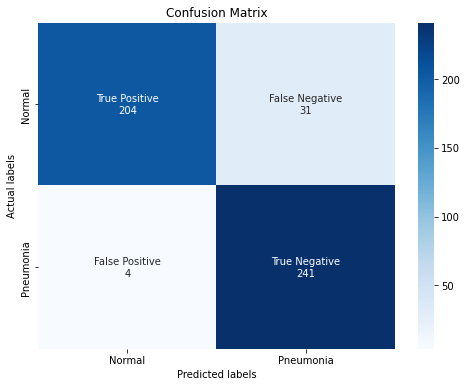

In [ ]:
group_names = ["True Positive","False Negative","False Positive","True Negative"]
group_counts = ['{0:0.0f}'.format(value) for value in cfm.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cfm, annot=labels, fmt='', cmap='Blues', ax = ax)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])
plt.show()

In [11]:
# image size
img_size= 512
img_input = Input(shape=(img_size, img_size, 1))
img_concate = Concatenate()([img_input, img_input, img_input])  

# loading VGG16 model
# include_top: whether to include the fully-connected layers at the top of the network.
model=VGG16(weights='imagenet', include_top=False, input_tensor=img_concate)

# making all layer trainable
for layer in model.layers:
    layer.trainable = True

# lets check the layer become trainable=Fale or Not.
for (i,layer) in enumerate(model.layers):
    print(str(i)+ " "+layer.__class__.__name__,layer.trainable)


# Now adding fully connected Layer on the ResNet101
flatLayer=model.output
fullConnected=Flatten()(flatLayer)

fullConnected=Dense(4,kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-4))(fullConnected)
fullConnected=BatchNormalization()(fullConnected)
fullConnected=Activation(activation='relu')(fullConnected)


output=Dense(1, activation='sigmoid')(fullConnected)
print("model.input:  ",model.input)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# Model summarary
model.summary()


from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0000015,beta_1=0.899,beta_2=0.999,epsilon=1e-07)

#compiling the cnn
model.compile(optimizer=opt , loss='binary_crossentropy',metrics=['accuracy'])

#part2- fitting the CNN to the images
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('/content/Dataset/Pneumonia_Chest _X-ray_Small_Dataset/Trainingdata',
        target_size=(512, 512),
        batch_size=16,
        color_mode='grayscale',
        class_mode='binary')

test_set = test_datagen.flow_from_directory('/content/Dataset/Pneumonia_Chest _X-ray_Small_Dataset/Testdata',
        target_size=(512,512),
        batch_size=8,
        color_mode='grayscale',
        shuffle=False,
        class_mode='binary')

print("test_set.class_indices: ",test_set.class_indices)
print("training_set.class_indices: ",training_set.class_indices)

# simple early stopping
my_callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=5,verbose=1)]

0 InputLayer True
1 Concatenate True
2 Conv2D True
3 Conv2D True
4 MaxPooling2D True
5 Conv2D True
6 Conv2D True
7 MaxPooling2D True
8 Conv2D True
9 Conv2D True
10 Conv2D True
11 MaxPooling2D True
12 Conv2D True
13 Conv2D True
14 Conv2D True
15 MaxPooling2D True
16 Conv2D True
17 Conv2D True
18 Conv2D True
19 MaxPooling2D True
model.input:   KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 512, 512, 3)  0           input_3[0][0]            

In [13]:
History = model.fit(training_set, 
                    validation_data= test_set, 
                    steps_per_epoch=len(training_set),
                    epochs=50,
                    validation_steps=len(test_set),
                    verbose=1,
                    callbacks=my_callbacks
                 )

Epoch 1/50
132/132 [==============================] - 325s 2s/step - loss: 2.0125 - accuracy: 0.9492 - val_loss: 2.0124 - val_accuracy: 0.9271
Epoch 2/50
132/132 [==============================] - 325s 2s/step - loss: 1.9673 - accuracy: 0.9563 - val_loss: 1.9699 - val_accuracy: 0.9271
Epoch 3/50
132/132 [==============================] - 325s 2s/step - loss: 1.9285 - accuracy: 0.9615 - val_loss: 1.9434 - val_accuracy: 0.9271
Epoch 4/50
132/132 [==============================] - 325s 2s/step - loss: 1.8796 - accuracy: 0.9701 - val_loss: 1.8893 - val_accuracy: 0.9271
Epoch 5/50
132/132 [==============================] - 325s 2s/step - loss: 1.8351 - accuracy: 0.9715 - val_loss: 1.8500 - val_accuracy: 0.9271
Epoch 6/50
132/132 [==============================] - 325s 2s/step - loss: 1.7927 - accuracy: 0.9753 - val_loss: 1.8111 - val_accuracy: 0.9333
Epoch 7/50
132/132 [==============================] - 325s 2s/step - loss: 1.7453 - accuracy: 0.9819 - val_loss: 1.7738 - val_accuracy: 0.9333

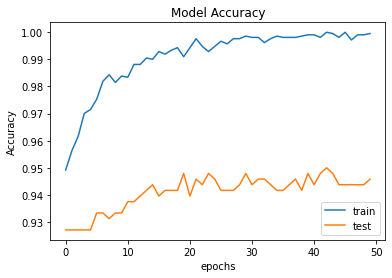

In [14]:
# summarize history for accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

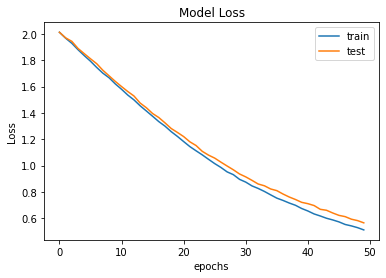

In [15]:
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [16]:
# calculate model's accuracy on test set with use of keras .evaluate_generator() function.
score = model.evaluate(test_set)
print("Test Accuracy: ",score[1]*100)

preds = model.predict(test_set)
y_preds = np.where(preds >=0.5, 1, 0)

cfm = confusion_matrix(test_set.classes, y_preds)
print("============Confusion Matrix=====================\n",cfm)
print("=========Classification_Report==================\n",classification_report(test_set.classes, y_preds))

60/60 [==============================] - 32s 523ms/step - loss: 0.5656 - accuracy: 0.9458
Test Accuracy:  94.58333253860474
============Confusion Matrix=====================
 [[218  17]
 [  9 236]]
=========Classification_Report==================
               precision    recall  f1-score   support

           0       0.96      0.93      0.94       235
           1       0.93      0.96      0.95       245

    accuracy                           0.95       480
   macro avg       0.95      0.95      0.95       480
weighted avg       0.95      0.95      0.95       480



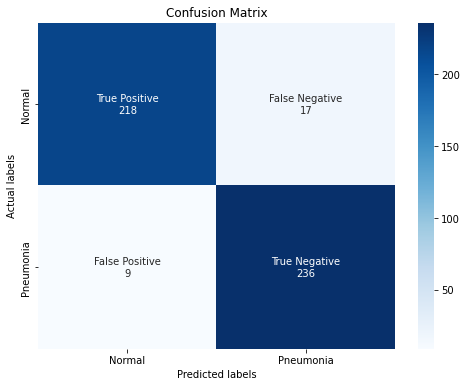

In [17]:
group_names = ["True Positive","False Negative","False Positive","True Negative"]
group_counts = ['{0:0.0f}'.format(value) for value in cfm.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cfm, annot=labels, fmt='', cmap='Blues', ax = ax)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])
plt.show()